# 1. Exploración de datos

In [1]:
# Import librerías para todo el preprocesamiento.

# básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import os
import joblib


# RegEx y strings
import re
import string
import unidecode

# Stopwords
import nltk
nltk.download('stopwords')          # Hay que descargarlo.
from nltk.corpus import stopwords

# Stemming
from nltk.stem import SnowballStemmer

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Train and test division
from sklearn.model_selection import train_test_split

# Vectorización de strings
# 1. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# Word2Vec w/ skip-gram
from gensim import models


# GloVe

# Configuración de gráficos
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iñigo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Leemos el dataset.
df = pd.read_csv(
    'dataset/SMSSpamCollection',
    sep="\t",
    names=['tipo', 'mensaje']       # Asigna nombres a las columnas
)

In [3]:
df.head(1)

,tipo,mensaje
0,ham,"Go until jurong point, crazy.. Available only ..."


# 1.1 Exploración inicial

In [4]:
df.groupby('tipo').describe()

mensaje                                                               
       count unique                                                top freq
tipo                                                                       
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

Dado que tenemos muy pocas dimensiones, vamos a extraer la mayor cantidad de datos posible.
Para empezar, asignamos un valor binario a la columna tipo (0 para mensaje normal, 1 para spam). Dado que no tenemos ningún tipo de información respecto a los mensajes, podríamos contar la longitud de los mensajes, así como tratar de identificar palabras clave asociados a los distintos tipos de mensajes.

Por otro lado, el dataset no está balanceado. Existen muchos más mensajes reales que de spam. Esto es muy común en los problemas de detección de transacciones fraudulentas y spam, dado que los fraudulentos son una minoría ínfima en comparación. La solución obvia sería conseguir más mensajes de spam; como esto no es sencillo, podríamos hacer resampling para balancear el dataset. 

In [5]:
# Longitud de los mensajes.
df['len_mensajes'] = df['mensaje'].apply(len)

Text(0.5, 0, 'Longitud de los mensajes por tipo de mensaje')

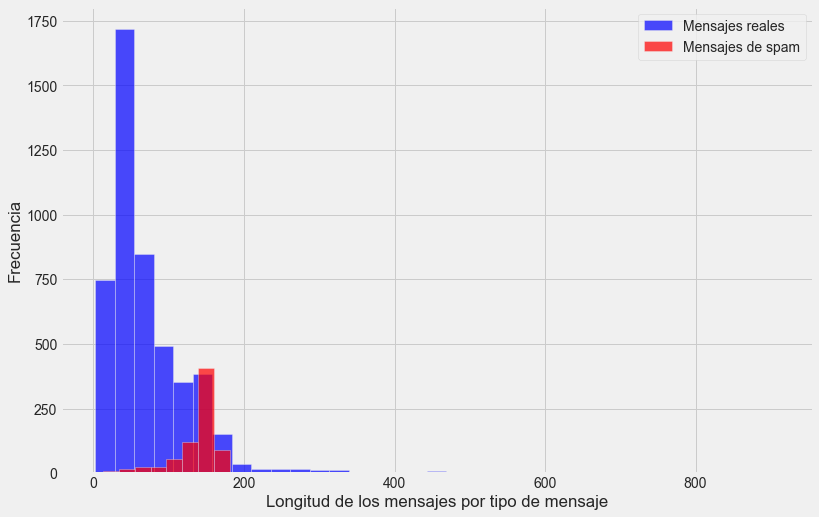

In [6]:
plt.figure(figsize=(12, 8))

df[df.tipo=='ham']['len_mensajes'].plot(
    bins=35, kind='hist', color='blue',
    label='Mensajes reales', alpha=0.7
    )

df[df.tipo=='spam']['len_mensajes'].plot(
    kind='hist', color='red',
    label='Mensajes de spam', alpha=0.7
    )

plt.legend()
plt.ylabel('Frecuencia')
plt.xlabel('Longitud de los mensajes por tipo de mensaje')


Podemos observar como los mensajes de spam tienen por lo general más caracteres que los reales. Por supuesto hay excepciones, pero la tendencia está clara.

In [7]:
df[df['tipo']=='ham'].describe()

,len_mensajes
count,4825.000000
mean,71.482902
std,58.442635
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [8]:
df[df['tipo']=='spam'].describe()

,len_mensajes
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


# 1.2 Extracción de meta datos

Vamos a tratar de extraer la máxima información posible escondida en los mensajes. Esta meta-información será utizada posteriormente en otro modelo de clasificación.

### 1.2.1 Links

In [9]:
# Tratamos de ver si algún mensaje tiene links.

def tiene_link(x):
    """ Evalua un string con regex y devuelve true si contiene un link.
    Regex obtenida de: http://urlregex.com/
    """
    expr = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    return expr.search(x) != None # True si tiene links.

In [10]:
df['tiene_link'] = df['mensaje'].apply(tiene_link)

In [11]:
df[df['tiene_link'] == True].groupby('tipo').describe()

len_mensajes                                                    
            count   mean        std   min    25%    50%    75%    max
tipo                                                                 
spam         19.0  133.0  25.309199  89.0  110.5  143.0  152.5  163.0

El 100% de los links son compartidos por mensajes fraudulentos. Esto no significa que todos los mensajes que tengan links sean malignos, pero si vemos un link deberíamos sospechar, y mucho.

### 1.2.2 Números de teléfono

In [12]:
def tiene_telefono(x):
    """ Evalua un string con regex y devuelve true si contiene un número de teléfono.
    Regex obtenida de: https://scripteverything.com/check-phone-numbers-using-regex-in-python-examples/
    """
    expr1 = re.compile(r'(?:\+\d{2})?\d{3,4}\D?\d{3}\D?\d{3}')      # Para teléfonos móviles
    expr2 = re.compile(r'(?:\+?\(?\d{2,3}?\)?\D?)?\d{4}\D?\d{4}')   # Para fijos
    
    return (expr1.search(x) != None 
        or expr2.search(x) != None)


In [13]:
df['tiene_telefono'] = df['mensaje'].apply(tiene_telefono)

In [14]:
df['tiene_telefono'].describe()

count      5572
unique        2
top       False
freq       5135
Name: tiene_telefono, dtype: object

In [15]:
df[df['tiene_telefono'] == True].groupby('tipo').describe()

len_mensajes                                                         
            count        mean        std   min    25%    50%    75%    max
tipo                                                                      
ham           3.0   99.333333  55.536775  51.0   69.0   87.0  123.5  160.0
spam        434.0  142.278802  25.690432  33.0  136.0  152.0  158.0  223.0

El ~0,7% de los mensajes que contienen un número de teléfono son reales, la inmensa mayoría restante son spam.

### 1.2.3 Palabras clave

Consiste en identificar las palabras clave presentes típicas presentes en cada tipo de mensaje. De tal forma, al leer un mensaje podemos identificar si contiene palabras asociadas al spam o a mensajes reales. Este paso se hará después de la limpieza de datos, en el apartado 2.

# 2. Preprocesamiento

## 2.1 Limpieza de datos

El objetivo de la limpieza de datos es facilitar la clasificación al modelo, reduciendo la dimensionalidad de los datos, descartando informacioń irrelevante y relacionando la existente de forma más evidente.

### 2.1.1 Signos de puntuación etc.

In [16]:
def limpiar_texto(x):
    """
    Devuelve el texto en minúsculas, libre de teléfonos, links, signos de puntuación, etc.
    """
    x = x.lower()                                                                                           # A minúsculas
    x = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x)     # Links
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x)                                               # Signos de puntuación, etc.
    x = re.sub('\n', '', x)                                                                                 # Saltos de línea
    x = re.sub('\w*\d\w*', '', x)                                                                           # Palabras con números
    x = re.sub('(?:\+\d{2})?\d{3,4}\D?\d{3}\D?\d{3}', '', x)                                                # Teléfonos móviles
    x = re.sub('(?:\+?\(?\d{2,3}?\)?\D?)?\d{4}\D?\d{4}', '', x)                                             # Teléfonos fijos
    x = unidecode.unidecode(x)
    

    return x.strip()

In [17]:
df['mensaje_limpio'] = df['mensaje'].apply(limpiar_texto)

In [18]:
df['mensaje_limpio']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in  a wkly comp to win fa cup final...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the  time we have tried  contact u u h...
5568                  will u b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: mensaje_limpio, Length: 5572, dtype: object

Como se puede ver, todavía hay mucho slang, palabras que no aportan información y otras expresiones que habría que limpiar.

Ahora queremos quitar las llamadas "stopwords", palabras como "a" y "the", que no aportan singificado extra al mensaje y son por tanto prescindibles.

### 2.1.2 Stopwords

In [19]:
stop_words = stopwords.words('english')
# Añadimos palabras extras detectadas manualmente.
extra_stop = [
        'dont', 'doin', 'rolf', 'u', 'b', 'ure', 'ur', 'im', 'c', 'its'
    ]
stop_words += extra_stop

def elima_stopwords(x):
    return ' '.join(palabra for palabra in x.split(' ') if palabra not in stop_words)

In [20]:
df['mensaje_limpio'] = df['mensaje_limpio'].apply(elima_stopwords)

In [21]:
df['mensaje_limpio']

0       go jurong point crazy available bugis n great ...
1                                   ok lar joking wif oni
2       free entry  wkly comp win fa cup final tkts  m...
3                           dun say early hor already say
4                  nah think goes usf lives around though
                              ...                        
5567     time tried  contact PS pound prize  claim eas...
5568                              going esplanade fr home
5569                         pity  mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: mensaje_limpio, Length: 5572, dtype: object

### 2.1.3 Stemming

Stemming es un método para reducir una palabra a su raíz. Por ejemplo: podemos tener un mensaje con write, writes, o writing. Nos interesa obtener la raíz de la palabra para quedarnos con el significado solamente. De los algoritmos de nltk, Snowball Stemmer ha demostrado ofrecer mejores resultados.

In [22]:
snowball = SnowballStemmer(language='english')

def stemming(x):
    return ' '.join(snowball.stem(palabra) for palabra in x.split(' '))

In [23]:
df['mensaje_limpio'] = df['mensaje_limpio'].apply(stemming)

In [24]:
df['mensaje_limpio']

0       go jurong point crazi avail bugi n great world...
1                                     ok lar joke wif oni
2       free entri  wkli comp win fa cup final tkts  m...
3                           dun say earli hor alreadi say
4                    nah think goe usf live around though
                              ...                        
5567     time tri  contact ps pound prize  claim easi ...
5568                                  go esplanad fr home
5569                             piti  mood soani suggest
5570    guy bitch act like id interest buy someth els ...
5571                                       rofl true name
Name: mensaje_limpio, Length: 5572, dtype: object

## 2.2 Palabra clave

Una vez tenemos los datos limpios, analizamos las palabras más frecuentes en los mensajes verídicos y en los de spam.

In [25]:
# Primero los mensajes normales.

mensajes_ham_en_lista = df[df['tipo']=='ham']['mensaje_limpio'].apply(
    lambda x: [palabra for palabra in x.split()]        # Dividimos cada mensaje en listas de palabras.
    )

palabras_clave_ham = Counter()


for mensaje in mensajes_ham_en_lista:
    palabras_clave_ham.update(mensaje)


In [26]:
print(palabras_clave_ham.most_common(50))

[('go', 417), ('get', 360), ('come', 295), ('call', 289), ('ltgt', 276), ('ok', 273), ('like', 244), ('know', 244), ('love', 241), ('ill', 240), ('got', 232), ('good', 225), ('time', 219), ('day', 215), ('want', 213), ('need', 176), ('one', 171), ('home', 160), ('lor', 160), ('see', 153), ('sorri', 153), ('think', 152), ('still', 147), ('take', 141), ('say', 138), ('tell', 138), ('n', 137), ('send', 135), ('make', 134), ('later', 134), ('today', 133), ('work', 132), ('da', 131), ('r', 131), ('back', 129), ('well', 127), ('ask', 126), ('hope', 120), ('cant', 120), ('happi', 119), ('miss', 118), ('meet', 117), ('hi', 117), ('oh', 112), ('much', 112), ('night', 112), ('thing', 111), ('wat', 108), ('give', 107), ('hey', 106)]


In [27]:
# Mensaje de spam

mensajes_spam_en_lista = df[df['tipo']=='spam']['mensaje_limpio'].apply(
    lambda x: [palabra for palabra in x.split()]        # Dividimos cada mensaje en listas de palabras.
    )

palabras_clave_spam = Counter()


for mensaje in mensajes_spam_en_lista:
    palabras_clave_spam.update(mensaje)


In [28]:
print(palabras_clave_spam.most_common(50))

[('call', 366), ('ps', 296), ('free', 216), ('txt', 150), ('text', 138), ('mobil', 135), ('claim', 115), ('stop', 115), ('repli', 109), ('prize', 94), ('get', 87), ('week', 86), ('tone', 73), ('servic', 72), ('send', 70), ('new', 69), ('nokia', 68), ('award', 66), ('urgent', 63), ('cash', 62), ('win', 61), ('contact', 61), ('phone', 57), ('pleas', 55), ('custom', 51), ('guarante', 51), ('collect', 50), ('min', 50), ('per', 46), ('messag', 45), ('chat', 44), ('draw', 39), ('number', 39), ('tri', 38), ('offer', 38), ('receiv', 37), ('latest', 37), ('line', 37), ('today', 36), ('voucher', 36), ('show', 35), ('go', 35), ('landlin', 34), ('camera', 33), ('box', 33), ('everi', 33), ('po', 32), ('holiday', 32), ('want', 32), ('select', 31)]


Hay una gran diferencia entre las palabras de spam y ham más comunes. Las de spam tratan de llamar la atención, pidiendo que llames, ofreciendo premios gratis (free, claim, reply, prize, cash, win, award), y pidiendo urgencia (urgent, today). Vamos a crear dos columnas extra: ham_score y spam_score. Esta puntuación se basará en el número de palabras comunes que contenga cada mensaje.

In [29]:
'call' in set(w for w,_ in palabras_clave_spam.most_common(50))

True

In [30]:
def count_words(x, counter_palabras, numero_comunes=50):
    lista_palabras = set(w for w,_ in counter_palabras.most_common(numero_comunes))
    count = 0
    for palabra in x.split():
        if palabra in lista_palabras:
            count+=1
    return count/numero_comunes

In [31]:
df['ham_score'] = df['mensaje_limpio'].apply(count_words, counter_palabras=palabras_clave_ham)

df['spam_score'] = df['mensaje_limpio'].apply(count_words, counter_palabras=palabras_clave_spam)

In [32]:
df.sort_values(by='spam_score', ascending=False).head(10)

,tipo,mensaje,len_mensajes,tiene_link,tiene_telefono,mensaje_limpio,ham_score,spam_score
3560,spam,URGENT! We are trying to contact U Todays draw...,156,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.26
3468,spam,URGENT! We are trying to contact U. Todays dra...,156,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24
2374,spam,XMAS Prize draws! We are trying to contact U. ...,157,False,True,xmas prize draw tri contact today draw show ps...,0.04,0.24
4036,spam,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,158,False,True,chosen receiv ps award pls call claim number ...,0.02,0.24
4967,spam,URGENT! We are trying to contact U. Todays dra...,159,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24
3217,spam,URGENT! We are trying to contact U. Todays dra...,158,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24
1687,spam,todays vodafone numbers ending with 0089(my la...,172,False,True,today vodafon number end last four digit sele...,0.04,0.24
962,spam,URGENT! We are trying to contact U. Todays dra...,156,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24
1673,spam,URGENT! We are trying to contact U. Todays dra...,157,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24
1072,spam,URGENT! We are trying to contact U. Todays dra...,156,False,True,urgent tri contact today draw show ps prize gu...,0.04,0.24


In [33]:
df.sort_values(by='ham_score', ascending=False).head(10)

,tipo,mensaje,len_mensajes,tiene_link,tiene_telefono,mensaje_limpio,ham_score,spam_score
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461,False,False,ltgt fast approach wish happi new year happi ...,0.50,0.02
1579,ham,How to Make a girl Happy? It's not at all diff...,611,False,False,make girl happi difficult make girl happi need...,0.50,0.00
1085,ham,For me the love should start with attraction.i...,910,False,False,love start attractioni feel need everi time ar...,0.38,0.10
2090,ham,No i'm not. I can't give you everything you wa...,363,False,False,cant give everyth want need actual could bette...,0.32,0.08
1863,ham,The last thing i ever wanted to do was hurt yo...,790,False,False,last thing ever want hurt didnt think would yo...,0.30,0.10
2434,ham,Indians r poor but India is not a poor country...,629,False,False,indian r poor india poor countri say one swiss...,0.28,0.06
3351,ham,Sorry i cant take your call right now. It so h...,368,False,False,sorri cant take call right happen r wat want ...,0.26,0.06
882,ham,"see, i knew giving you a break a few times wou...",276,False,False,see knew give break time woul lead alway want ...,0.24,0.04
2946,ham,"Hey babe, sorry i didn't get sooner. Gary can ...",327,False,False,hey babe sorri didnt get sooner gari come fix ...,0.24,0.06
4081,ham,"Sir, good morning. Hope you had a good weekend...",276,False,False,sir good morn hope good weekend call let know ...,0.22,0.02


Podemos observar que entre los mensajes con mayor ham_score hay mensajes de spam. Este no es el caso a la inversa, por lo que nos quedaremos con la spam_score, que demuestra ser la métrica más precisa.

In [34]:
df.drop('ham_score', axis=1, inplace=True)

Quitamos True y False y los convertimos a 1 y 0.

In [35]:
df['tipo_num'] = df['tipo'].map({'ham':0, 'spam':1})
df['tiene_link'] = df['tiene_link'].map({False:0, True:1})
df['tiene_telefono'] = df['tiene_telefono'].map({False:0, True:1})

In [36]:
# Guardamos el dataset antes de la vectorización.
df_json = df.to_json(orient="records")
parsed = json.loads(df_json)

with open("dataset/spam_agregado.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, indent=4)

## 2.3 Vectorización

El objetivo de este apartado es probar distintos tipos de algoritmos de vectorización de os mensajes, para posteriormente comprobar la eficacia de los mismos a la hora de clasificar y detectar los mensajes de spam. Para ello, vamos a estudiar 2 algoritmos que han obtenido buenos resultados en la literatura científica. Concretamente utilizaremos: TF-IDF y Word2Vec. [Fuente](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide)

Antes de nada, vamos a terminar de limpiar el dataset.

In [37]:
df.columns

Index(['tipo', 'mensaje', 'len_mensajes', 'tiene_link', 'tiene_telefono',
       'mensaje_limpio', 'spam_score', 'tipo_num'],
      dtype='object')

In [38]:
# Quitamos las columnas que no vamos a usar.
df.drop(
    ['tipo', 'mensaje'],
    axis=1, inplace=True)

In [39]:
df.head(2)

,len_mensajes,tiene_link,tiene_telefono,mensaje_limpio,spam_score,tipo_num
0,111,0,0,go jurong point crazi avail bugi n great world...,0.02,0
1,29,0,0,ok lar joke wif oni,0.00,0


Tenemos que normalizar la longitud del mensaje y la spam_score.

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
arr = np.array(df['len_mensajes']).reshape(-1,1)
scaler.fit(arr)
df['len_mensajes'] = scaler.transform(arr)

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))
arr = np.array(df['spam_score']).reshape(-1,1)
scaler.fit(arr)
df['spam_score'] = scaler.transform(arr)

In [42]:
df.head(2)

,len_mensajes,tiene_link,tiene_telefono,mensaje_limpio,spam_score,tipo_num
0,0.120044,0,0,go jurong point crazi avail bugi n great world...,0.076923,0
1,0.029736,0,0,ok lar joke wif oni,0.000000,0


Una vez tenemos un dataset limpio, creamos un dataset de entrenamiento y otro de test.

In [43]:
# Separamos el dataset en x e y. Y conteniendo las etiquetas que indican si el mensaje es spam o no, y X el resto de la información.
y = df['tipo_num']
x = df.drop('tipo_num', axis=1)

print(x.shape,y.shape)

(5572, 5) (5572,)


In [44]:
# Ahora los dividimos en dataset de entrenamiento y de test.
x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4179, 5) (4179,)
(1393, 5) (1393,)


In [45]:
# Guardamos x_test para posteriormente poder leer los mensajes de spam.
path = 'dataset/test'

if not os.path.exists(path):
    os.makedirs(path)


x_test.to_pickle(os.path.join(path,"x_test"))


### 2.3.1 TF-IDF

In [46]:
# Vectorizamos los mensajes.
vectorizer = TfidfVectorizer()

vectorizer = vectorizer.fit(x_train['mensaje_limpio'])

x_train_tfidf =  vectorizer.transform(x_train['mensaje_limpio'])

x_test_tfidf = vectorizer.transform(x_test['mensaje_limpio'])

In [47]:
path = 'dataset/vectorizado'

if not os.path.exists(path):
    os.makedirs(path)

# Guardamos las sparse matrix.
sparse.save_npz(os.path.join(path, "tfidf_train.npz"), x_train_tfidf)

sparse.save_npz(os.path.join(path, "tfidf_test.npz"), x_test_tfidf)


#your_matrix_back = sparse.load_npz("yourmatrix.npz")


# Guardamos también el TfidfVectorizer
joblib.dump(vectorizer.vocabulary_,os.path.join(path, "vocabulario_vectorizador"))

['dataset/vectorizado\\vocabulario_vectorizador']

In [48]:
path = 'dataset/labels'

if not os.path.exists(path):
    os.makedirs(path)

# Guardamos las etiquetas (Y).

y_train.to_pickle(os.path.join(path,"y_train"))

y_test.to_pickle(os.path.join(path,"y_test"))
